In [1]:
import warnings
import pandas as pd 
import IPython.display as ipd
from src.utility_trance import load_dataset_song_split, get_songs_split, logistic_test_performance, plot_label_frequencies
from src.utility_trance import create_mfcc_dataset, load_dataset_previous_split, mfcc_test_performance, plot_min_major
from src.utility_trance import create_melspectrogram_dataset, create_mel_vizualizations, create_trance_df, plot_keys, print_logistic_coefficients
from src.models_trance import regularized_validation_logistic_regression, mfcc_ffnn
from src.trainer_trance import train_slice_lengths_crnn
from src.representation_trance import plot_mel_tsne

Using TensorFlow backend.


## Exploratory Analysis

### Metadata

In [4]:
trance_df = create_trance_df(my_path = './electronic_music/Trance_label/6/')

trance_df.head()

,BPM,Genre,Label,Song_name,Key,Artists,Length,Song_file,Length_minutes,Min_or_Maj
0,132,Trance,Coldharbour,Viola (Elevation Extended Remix).mp3,8A,Moogwai,407.0,8A - 132 - Moogwai - Viola (Elevation Extended...,6.783333,Min
1,132,Trance,Coldharbour,Searching (Daxson Extended Remix).mp3,9A,Markus Schulz Presents Dakota,410.0,9A - 132 - Markus Schulz Presents Dakota - Sea...,6.833333,Min
2,128,Trance,Coldharbour,Opera of Northern Ocean (Nifra Extended Remix...,3A,Rex Mundi,367.0,3A - 128 - Rex Mundi - Opera of Northern Ocean...,6.116667,Min
3,134,Trance,Coldharbour,Fire Which Burns Us All (Extended Mix).mp3,5A,Driftmoon & Robert Nickson Present Astrosphere,395.0,5A - 134 - Driftmoon & Robert Nickson Present ...,6.583333,Min
4,131,Trance,Coldharbour,Edge of Time (Artento Divini Extended Mix).mp3,5A,Nifra Feat Seri,353.0,5A - 131 - Nifra Feat Seri - Edge of Time (Art...,5.883333,Min


In [3]:
trance_df["Genre"].unique()

array(['Trance'], dtype=object)

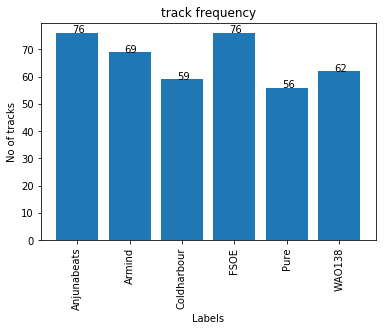

In [5]:
plot_label_frequencies(trance_df=trance_df)

### BPM varaince

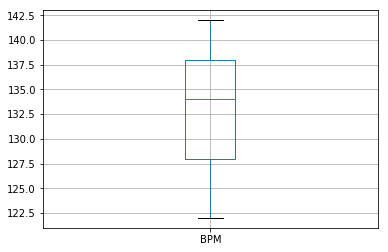

In [6]:
trance_df.boxplot(column=['BPM'])

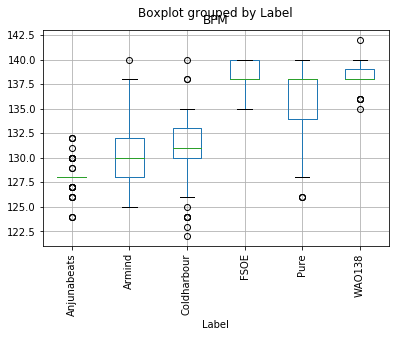

In [7]:
trance_df.boxplot(column=['BPM'], by="Label", rot=90)

### Song length variance (Minutes)

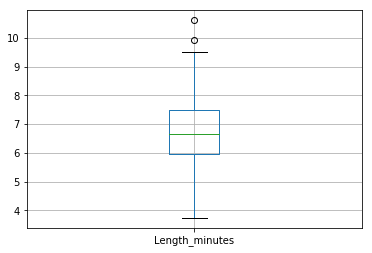

In [8]:
trance_df.boxplot(column=['Length_minutes'])

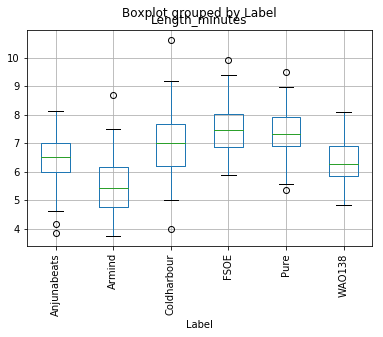

In [9]:
trance_df.boxplot(column=['Length_minutes'], by="Label", rot=90)

### Key distribution

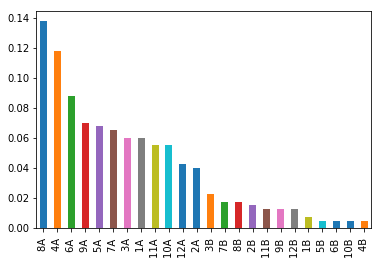

In [10]:
data = trance_df["Key"].value_counts()
data = data/data.sum()
data.plot(kind='bar')

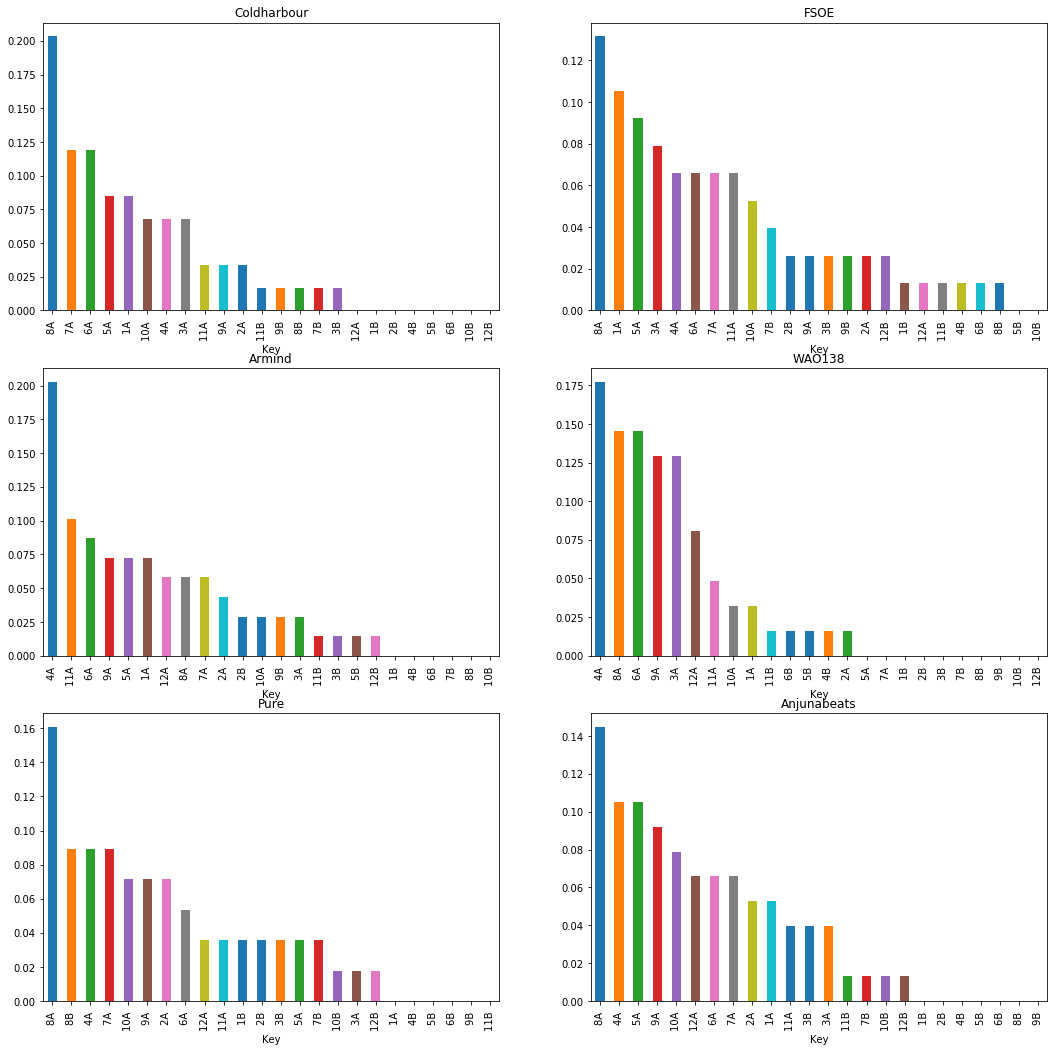

In [11]:
plot_keys(trance_df, sort_index=False)

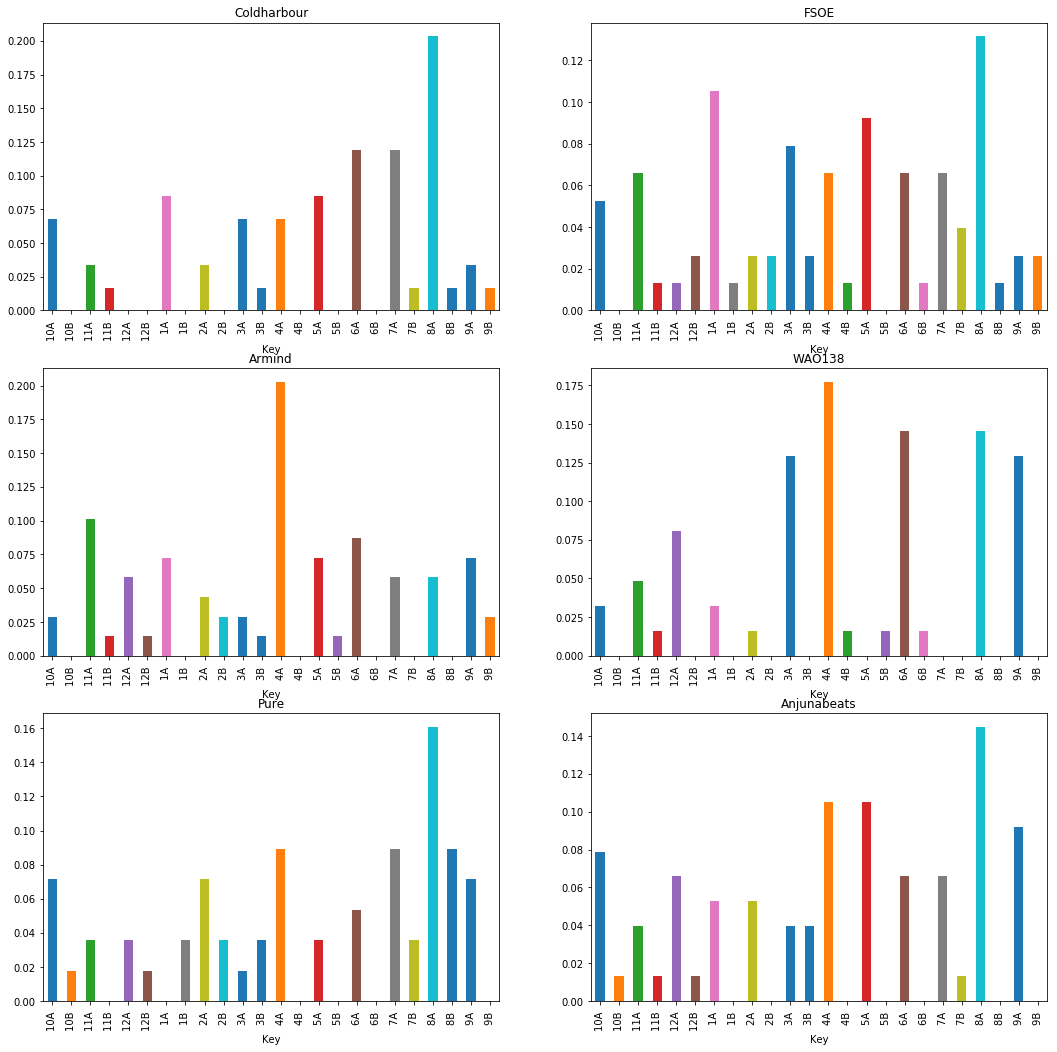

In [12]:
plot_keys(trance_df, sort_index=True)

### Key distribution (Minor and Mayor) 

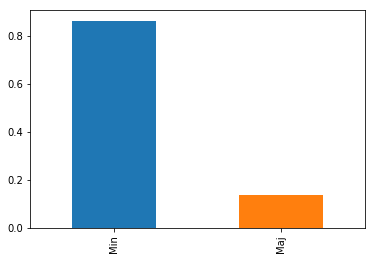

In [13]:
data = trance_df["Min_or_Maj"].value_counts()
data = data/data.sum()
data.plot(kind='bar')

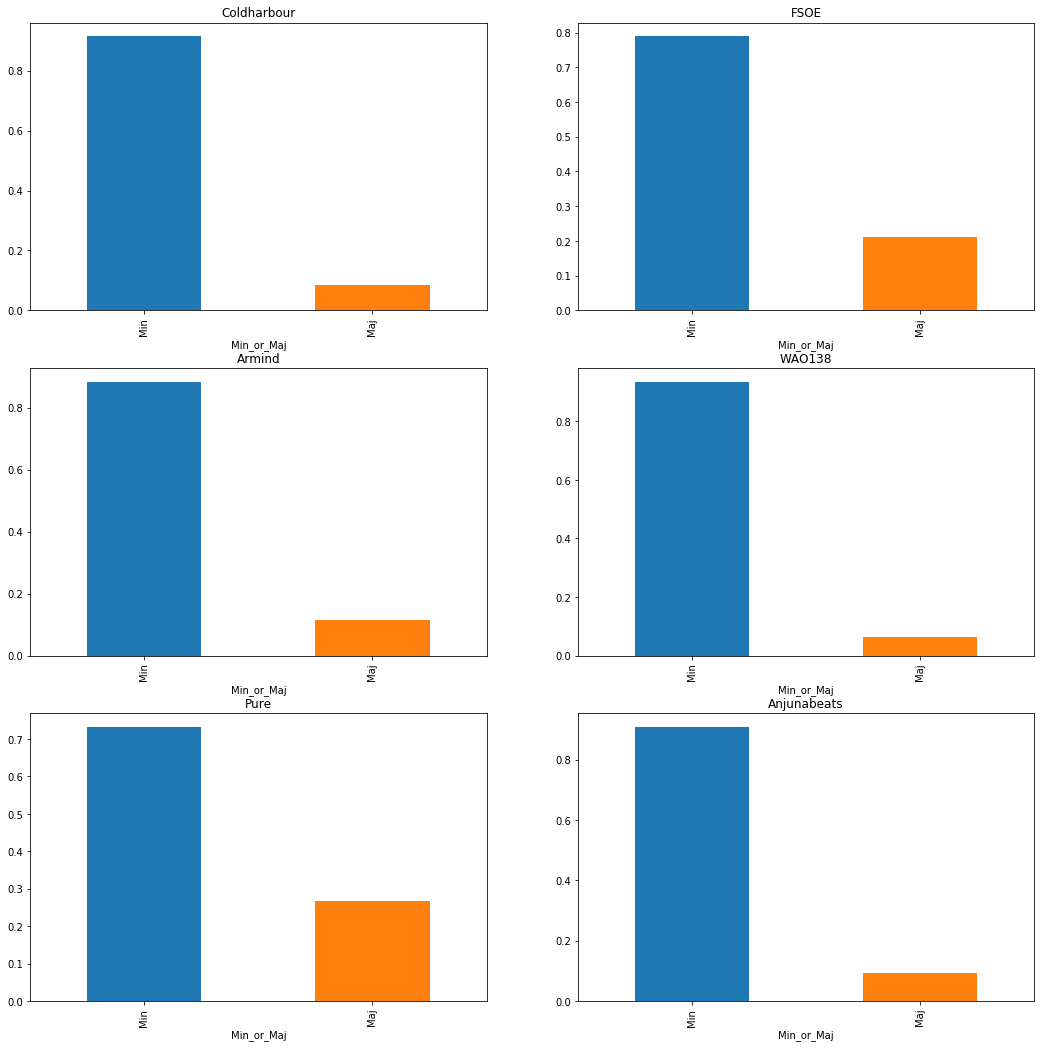

In [14]:
plot_min_major(trance_df)

## Logistic Regression

### Data

In [15]:
logistic_data = pd.get_dummies(trance_df[['BPM', 'Key', 'Length', 'Min_or_Maj']])
logistic_data['BPM_x_Length'] = logistic_data['BPM']*logistic_data['Length']
logistic_data.head()

,BPM,Length,Key_10A,Key_10B,Key_11A,Key_11B,Key_12A,Key_12B,Key_1A,Key_1B,...,Key_6B,Key_7A,Key_7B,Key_8A,Key_8B,Key_9A,Key_9B,Min_or_Maj_Maj,Min_or_Maj_Min,BPM_x_Length
0,132,407.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,53724.0
1,132,410.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,54120.0
2,128,367.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,46976.0
3,134,395.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,52930.0
4,131,353.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,46243.0


In [16]:
Y_train, X_train, S_train, \
Y_test, X_test, S_test, \
Y_val, X_val, S_val = load_dataset_song_split(X=logistic_data, 
                                              Y=trance_df[['Label']] , 
                                              S=trance_df[['Song_file']], 
                                              test_split_size=0.1,
                                              validation_split_size=0.1, 
                                              random_state=42)

train_songs, val_songs, test_songs = get_songs_split(S_train, S_val, S_test)

### Train Model

In [17]:
best_performance, logistic_model = regularized_validation_logistic_regression(X_train=X_train, 
                                                                              Y_train=Y_train.values.ravel(), 
                                                                              X_val=X_val, 
                                                                              Y_val=Y_val.values.ravel(), 
                                                                              inverse_regularization_strength=[.1, .5, 1, 2, 5, 10],
                                                                              n_classes=6)

best_performance

{'best_accuracy': 0.6388888888888888, 'inverse_constant': 0.1}

In [18]:
print_logistic_coefficients(logistic_model=logistic_model, 
                            logistic_data=logistic_data)

Anjunabeats 

('Length', 0.1940330640951185)
('BPM', 0.03188794962435424)
('Min_or_Maj_Min', 0.0019707372141593914)
('Key_2A ', 0.0010318655763761266)
('Key_5A ', 0.0010086421487475136)
('Key_10A ', 0.0009791858407890385)
('Key_3B ', 0.0007003630523116769)
('Key_12A ', 0.0006424525567920326)
('Key_3A ', 0.00033673670977571864)
('Key_10B ', 0.0003123875834575372)
('Key_6A ', 0.00023846612646785778)
('Key_8A ', 0.00020798264745705938)
('Key_9A ', 4.774643691874878e-05)
('Key_1B ', -2.2268609269297392e-05)
('Key_4B ', -3.0586845680293264e-05)
('Key_6B ', -6.243110511406375e-05)
('Key_5B ', -0.0001394757403288278)
('Key_7B ', -0.00019582409732877822)
('Key_4A ', -0.0002280735412951623)
('Key_2B ', -0.0002935621159628243)
('Key_8B ', -0.0003075031473135594)
('Key_12B ', -0.0003488813659265131)
('Key_11B ', -0.00040552712296247314)
('Key_9B ', -0.0004225648900896026)
('Key_11A ', -0.0007255619915801601)
('Key_7A ', -0.000739373750732637)
('Key_1A ', -0.0008293315460771502)
('Min_or_Maj_Maj',

In [19]:
test_accuracy, scores, scores_dict = logistic_test_performance(X_test=X_test, 
                                                               Y_test=Y_test,
                                                               n_labels=6,
                                                               logistic_model=logistic_model, 
                                                               save_metrics=True, 
                                                               plot_folder='./metrics_plots_logistic')

print('Test accuracy:', test_accuracy)
print('\nTest results on each slice:')
print(scores)

Test accuracy: 0.65

Test results on each slice:
              precision    recall  f1-score   support

 Anjunabeats       0.64      0.88      0.74         8
      Armind       0.71      0.71      0.71         7
 Coldharbour       0.60      0.50      0.55         6
        FSOE       0.58      0.88      0.70         8
        Pure       0.00      0.00      0.00         5
      WAO138       0.80      0.67      0.73         6

   micro avg       0.65      0.65      0.65        40
   macro avg       0.56      0.61      0.57        40
weighted avg       0.58      0.65      0.60        40



<Figure size 1008x1008 with 0 Axes>

![caption](./metrics_plots_logistic/logistic_6.png)

## (Deep) FeedFoward Neural Network

### Data

In [20]:
create_mfcc_dataset(label_folder='./electronic_music/Trance_label/6/', 
                    song_duration=180.0,
                    save_folder='song_mfccs_label_data/6', 
                    sr=44100,
                    create_dataset=False) 

Y_train, X_train, S_train, \
Y_test, X_test, S_test, \
Y_val, X_val, S_val = load_dataset_previous_split(train_songs=train_songs, 
                                                  val_songs=val_songs, 
                                                  test_songs=test_songs, 
                                                  song_folder_name='song_mfccs_label_data/6/')

### Train Model

In [21]:
mfcc_model = mfcc_ffnn(X_train=X_train, 
                       Y_train=Y_train, 
                       X_val=X_val, 
                       Y_val=Y_val, 
                       n_classes=6, 
                       save_weights_folder='weights_mfcc', 
                       random_state=42, 
                       verbose=True, 
                       early_stop=30, 
                       batch_size=16, 
                       epochs=200, 
                       train=False, 
                       load_checkpoint=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               10496     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0      

### Performance

In [22]:
score, scores, scores_dict = mfcc_test_performance(X_test=X_test, 
                                                   Y_test=Y_test, 
                                                   model=mfcc_model, 
                                                   n_classes=6, 
                                                   save_metrics=True, 
                                                   plot_folder='./metrics_plots_mfcc')

print('Test score/loss:', score[0])
print('Test accuracy:', score[1])
print('\nTest results on each slice:')
print(scores)

Test score/loss: 1.8314266681671143
Test accuracy: 0.225

Test results on each slice:
              precision    recall  f1-score   support

 Anjunabeats       0.12      0.12      0.12         8
      Armind       0.33      0.14      0.20         7
 Coldharbour       1.00      0.17      0.29         6
        FSOE       0.17      0.12      0.14         8
        Pure       0.30      0.60      0.40         5
      WAO138       0.17      0.33      0.22         6

   micro avg       0.23      0.23      0.23        40
   macro avg       0.35      0.25      0.23        40
weighted avg       0.33      0.23      0.21        40



<Figure size 1008x1008 with 0 Axes>

![caption](./metrics_plots_mfcc/mfcc_6.png)

## Convolutional Recurrent Neural Netowrk

### Data

In [23]:
create_melspectrogram_dataset(label_folder='electronic_music/Trance_label/6/', 
                              save_folder='song_mel_label_data/6',
                              sr=44100, 
                              n_mels=128, 
                              n_fft=2048, 
                              hop_length=512, 
                              song_duration=180.0,
                              create_data=False)

### Vizualize data

In [24]:
create_mel_vizualizations(song_path='electronic_music/Trance_label/6/Anjunabeats/10A - 128 - Above & Beyond - Distorted Truth (Extended Mix).mp3', 
                          label_folder='electronic_music/Trance_label/6/',
                          n_classes=6,
                          plot_folder='spectogram_mel', 
                          create_visuals=False, 
                          save_visuals=True, 
                          song_duration=180.0)

![caption](./spectogram_mel/10A-128-Above&Beyond-DistortedTruth(ExtendedMix).png)

![caption](./spectogram_mel/spectrograms_6.png)

### Train Model and Performance

* Frames to seconds for 44100 sample rate songs:  
    
    1s - 86 frames    
    3s - 258 frames    
    5s - 430 frames       
    10s - 861 frames     
    20s - 1722 frames          
    30s - 2584 frames   
    180s - 15504 frames 

Training for slice length of 2584 

Training set label counts: (array(['Anjunabeats', 'Armind', 'Coldharbour', 'FSOE', 'Pure', 'WAO138'],
      dtype='<U11'), array([366, 336, 288, 366, 276, 300])) 

model summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 128, 2584, 1)      512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 2584, 64)     640       
_________________________________________________________________
activation_4 (Activation)    (None, 128, 2584, 64)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 2584, 64)     256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 1292, 64)      0         
____________________________________________________________

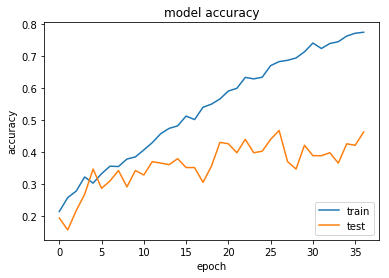

Test score/loss: 1.3790717522303264
Test accuracy: 0.475

Test results on each slice:
              precision    recall  f1-score   support

 Anjunabeats       0.49      0.69      0.57        48
      Armind       0.52      0.55      0.53        42
 Coldharbour       0.36      0.33      0.35        36
        FSOE       0.49      0.40      0.44        48
        Pure       0.38      0.37      0.37        30
      WAO138       0.57      0.44      0.50        36

   micro avg       0.47      0.47      0.48       240
   macro avg       0.47      0.46      0.46       240
weighted avg       0.48      0.47      0.47       240

Test results when pooling slices by song and voting:
              precision    recall  f1-score   support

 Anjunabeats       0.50      0.88      0.64         8
      Armind       0.43      0.43      0.43         7
 Coldharbour       0.50      0.33      0.40         6
        FSOE       0.38      0.38      0.38         8
        Pure       0.67      0.40      0.50    

In [25]:
%%time
slice_lengths = [2584] #[1722, 861, 430, 258, 86]

best_accuracy, best_slice_len = train_slice_lengths_crnn(train_songs=train_songs, 
                                                         val_songs=val_songs, 
                                                         test_songs=test_songs, 
                                                         slice_lengths=slice_lengths, 
                                                         song_folder='song_mel_label_data/6', 
                                                         n_classes=6, 
                                                         train=False,
                                                         load_check_point=True, 
                                                         save_metrics_folder='metrics_plots_mel',
                                                         save_weights_folder='weights_mel', 
                                                         batch_size=16, 
                                                         nb_epochs=200, 
                                                         early_stop=10, 
                                                         lr=0.0001,
                                                         random_state=42, 
                                                         summary_metrics_output_folder='summary_mel')

#### Overall metrics

![caption](./metrics_plots_mel/6_2584_42.txt.png)

#### Pooled metrics

![caption](./metrics_plots_mel/6_2584_42.txt_pooled.png)

## t-SNE 

### Frame level

In [2]:
plot_mel_tsne(random_state=42, 
              slice_length=2584, 
              nb_classes=6, 
              weights_path='weights_mel',
              folder='song_mel_label_data/6', 
              ensemble_visual=False, 
              save_path='tSNE_mel', 
              trance_df=None)

Loading data for 2584


/home/kike/miniconda3/envs/trance_classification/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Checkpoint file detected. Loading weights. 

Modifying model and predicting representation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 128, 2584, 1)      512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 2584, 64)     640       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 2584, 64)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 2584, 64)     256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 1292, 64)      0         
_____________________________________

![caption](./tSNE_mel/6_2584_label.png)

### Song level

In [5]:
plot_mel_tsne(random_state=42, 
              slice_length=2584, 
              nb_classes=6, 
              weights_path='weights_mel',
              folder='song_mel_label_data/6', 
              ensemble_visual=True, 
              save_path='tSNE_mel', 
              trance_df=trance_df)

Loading data for 2584


/home/kike/miniconda3/envs/trance_classification/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Checkpoint file detected. Loading weights. 

Modifying model and predicting representation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 128, 2584, 1)      512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 2584, 64)     640       
_________________________________________________________________
activation_6 (Activation)    (None, 128, 2584, 64)     0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 2584, 64)     256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 1292, 64)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 1292, 64)      0         
___________________________________________________

#### Label

![caption](./tSNE_mel/6_2584_ensemble_label.png)

#### BPM

![caption](./tSNE_mel/6_2584_ensemble_bpm.png)

#### Min or major

![caption](./tSNE_mel/6_2584_ensemble_mm.png)